In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
bio = pd.read_csv(
    "api_data_aadhar_biometric_0_500000.csv",
    usecols=[
        "date", "state", "district", "pincode",
        "bio_age_5_17", "bio_age_17_"
    ]
)

enr = pd.read_csv(
    "api_data_aadhar_enrolment_0_500000.csv",
    usecols=[
        "date", "state", "district", "pincode",
        "age_0_5", "age_5_17", "age_18_greater"
    ]
)

demo = pd.read_csv(
    "api_data_aadhar_demographic_0_500000.csv",
    usecols=[
        "date", "state", "district", "pincode",
        "demo_age_5_17", "demo_age_17_"
    ]
)

In [3]:
bio_agg = bio.groupby(
    ["date", "state", "district", "pincode"],
    as_index=False
).sum()

enr_agg = enr.groupby(
    ["date", "state", "district", "pincode"],
    as_index=False
).sum()

demo_agg = demo.groupby(
    ["date", "state", "district", "pincode"],
    as_index=False
).sum()

In [4]:
data = bio_agg.merge(
    demo_agg,
    on=["date", "state", "district", "pincode"],
    how="inner"
).merge(
    enr_agg,
    on=["date", "state", "district", "pincode"],
    how="inner"
)

In [5]:
data["total_biometric"] = (
    data["bio_age_5_17"] + data["bio_age_17_"]
)

data["total_demographic"] = (
    data["demo_age_5_17"] + data["demo_age_17_"]
)

data["total_enrolment"] = (
    data["age_0_5"] + data["age_5_17"] + data["age_18_greater"]
)

data["total_activity"] = (
    data["total_biometric"] +
    data["total_demographic"] +
    data["total_enrolment"]
)

In [6]:
threshold = data["total_activity"].quantile(0.70)
data = data[data["total_activity"] >= threshold]

In [7]:
data["bio_demo_ratio"] = (
    data["total_biometric"] / (data["total_demographic"] + 1)
)

data["child_bio_ratio"] = (
    data["bio_age_5_17"] / (data["bio_age_17_"] + 1)
)

data["enrolment_update_ratio"] = (
    data["total_enrolment"] /
    (data["total_biometric"] + data["total_demographic"] + 1)
)

data["biometric_enrolment_ratio"] = (
    data["total_biometric"] / (data["total_enrolment"] + 1)
)

C:\Users\ARPAN\AppData\Local\Temp\ipykernel_2012\4185853566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["bio_demo_ratio"] = (
C:\Users\ARPAN\AppData\Local\Temp\ipykernel_2012\4185853566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["child_bio_ratio"] = (
C:\Users\ARPAN\AppData\Local\Temp\ipykernel_2012\4185853566.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [8]:
features = [
    "bio_age_5_17",
    "bio_age_17_",
    "demo_age_5_17",
    "demo_age_17_",
    "age_0_5",
    "age_5_17",
    "age_18_greater",
    "bio_demo_ratio",
    "child_bio_ratio",
    "enrolment_update_ratio",
    "biometric_enrolment_ratio",
    "total_activity"
]

X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42
)

data["fraud_flag"] = model.fit_predict(X_scaled)
data["fraud_score"] = model.decision_function(X_scaled)

In [10]:
data["risk_level"] = "Low"
data.loc[data["fraud_flag"] == -1, "risk_level"] = "High"

medium_threshold = data["fraud_score"].quantile(0.10)
data.loc[data["fraud_score"] < medium_threshold, "risk_level"] = "Medium"

In [11]:
fraud_cases = data[data["fraud_flag"] == -1] \
    .sort_values("fraud_score")

fraud_cases.to_csv("fraud_alerts.csv", index=False)

fraud_cases.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_demographic,total_enrolment,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level
122,01-05-2025,Uttar Pradesh,Moradabad,244001,4905,3381,1184,9688,1673,793,...,10872,2545,21703,0.762071,1.450325,0.132836,3.254517,-1,-0.290447,Medium
172,01-07-2025,Delhi,West Delhi,110059,3046,4231,1346,9576,1538,640,...,10922,2300,20499,0.666209,0.719754,0.126374,3.162538,-1,-0.290447,Medium
11,01-04-2025,Delhi,West Delhi,110059,5003,7201,1780,14314,974,344,...,16094,1469,29767,0.758248,0.694668,0.051910,8.302041,-1,-0.290345,Medium
219,01-07-2025,Uttar Pradesh,Aligarh,202001,5082,3522,1067,11142,1436,1351,...,12209,2845,23658,0.704668,1.442521,0.136687,3.023190,-1,-0.289582,Medium
57,01-04-2025,Uttar Pradesh,Aligarh,202001,5750,2230,977,9397,1066,643,...,10374,1767,20121,0.769157,2.577320,0.096268,4.513575,-1,-0.286704,Medium


In [12]:
fraud_cases.tail()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_demographic,total_enrolment,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level
41730,09-09-2025,Uttar Pradesh,Siddharthnagar,272153,55,35,47,195,18,34,...,242,52,384,0.370370,1.527778,0.156156,1.698113,-1,-9.904957e-04,Medium
21617,04-09-2025,West Bengal,Uttar Dinajpur,733210,37,53,20,320,44,19,...,340,63,493,0.263930,0.685185,0.146172,1.406250,-1,-9.466068e-04,Medium
5439,01-09-2025,Uttar Pradesh,Lalitpur,284403,109,40,44,211,16,9,...,255,26,430,0.582031,2.658537,0.064198,5.518519,-1,-7.956967e-04,Medium
38747,09-09-2025,Madhya Pradesh,Guna,473001,125,141,21,80,50,8,...,101,58,425,2.607843,0.880282,0.157609,4.508475,-1,-2.620791e-04,Medium
30524,08-09-2025,Chhattisgarh,Durg,491001,36,165,23,138,7,3,...,161,12,374,1.240741,0.216867,0.033058,15.461538,-1,-8.353146e-08,Medium


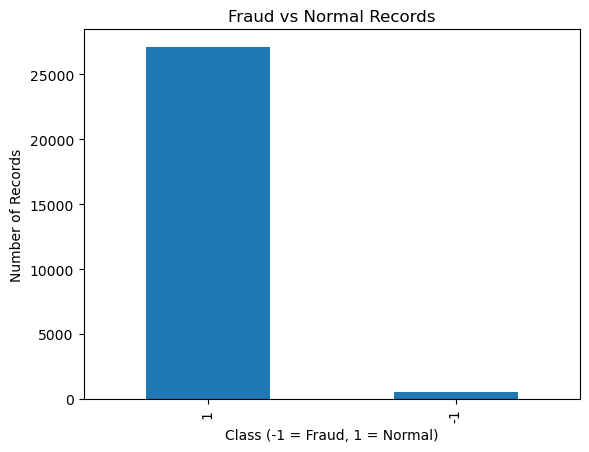

In [13]:
data["fraud_flag"].value_counts().plot(
    kind="bar",
    title="Fraud vs Normal Records",
    xlabel="Class (-1 = Fraud, 1 = Normal)",
    ylabel="Number of Records"
)

plt.show() 

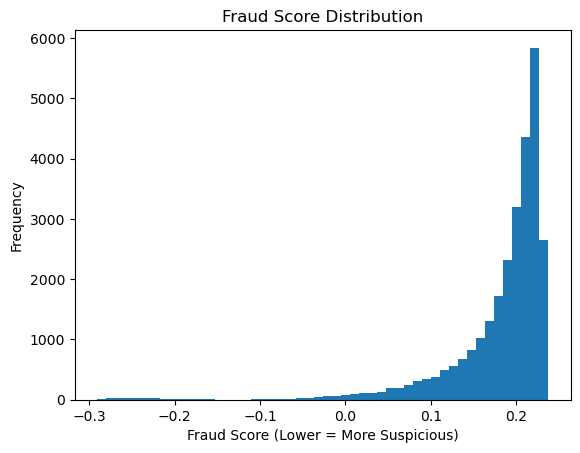

In [14]:
plt.hist(data["fraud_score"], bins=50)
plt.title("Fraud Score Distribution")
plt.xlabel("Fraud Score (Lower = More Suspicious)")
plt.ylabel("Frequency")
plt.show()

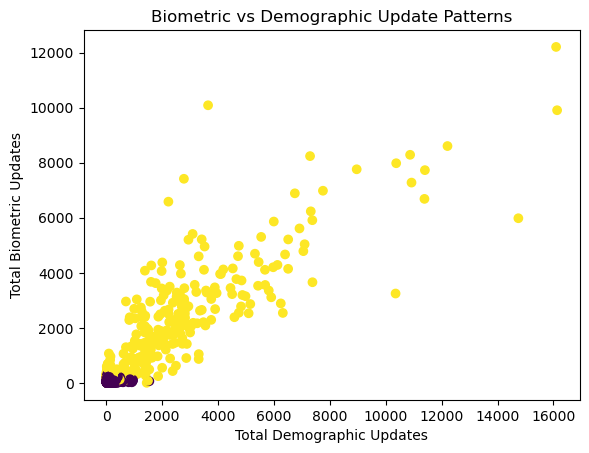

In [15]:
plt.scatter(
    data["total_demographic"],
    data["total_biometric"],
    c=(data["fraud_flag"] == -1)
)

plt.xlabel("Total Demographic Updates")
plt.ylabel("Total Biometric Updates")
plt.title("Biometric vs Demographic Update Patterns")
plt.show()

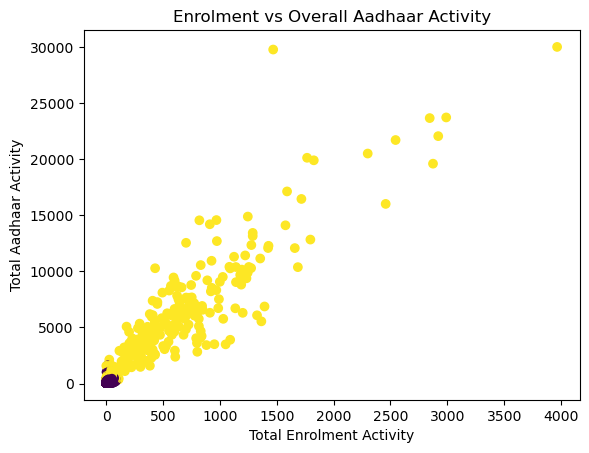

In [16]:
plt.scatter(
    data["total_enrolment"],
    data["total_activity"],
    c=(data["fraud_flag"] == -1)
)

plt.xlabel("Total Enrolment Activity")
plt.ylabel("Total Aadhaar Activity")
plt.title("Enrolment vs Overall Aadhaar Activity")
plt.show()

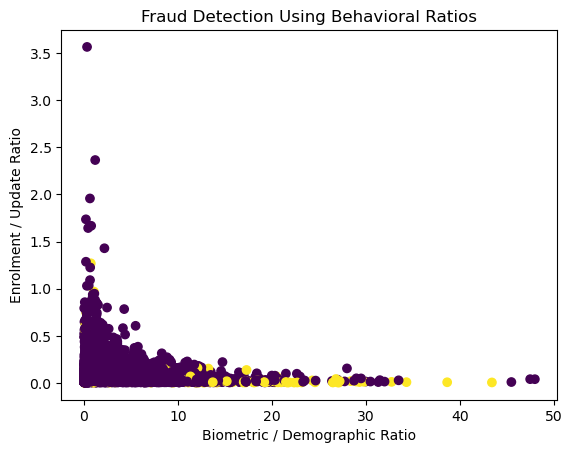

In [17]:
plt.scatter(
    data["bio_demo_ratio"],
    data["enrolment_update_ratio"],
    c=(data["fraud_flag"] == -1)
)

plt.xlabel("Biometric / Demographic Ratio")
plt.ylabel("Enrolment / Update Ratio")
plt.title("Fraud Detection Using Behavioral Ratios")
plt.show()

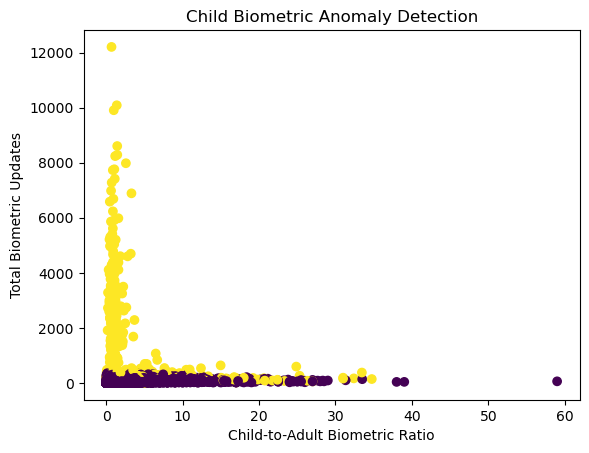

In [18]:
plt.scatter(
    data["child_bio_ratio"],
    data["total_biometric"],
    c=(data["fraud_flag"] == -1)
)

plt.xlabel("Child-to-Adult Biometric Ratio")
plt.ylabel("Total Biometric Updates")
plt.title("Child Biometric Anomaly Detection")
plt.show()

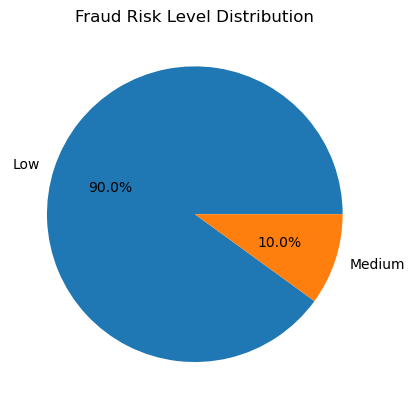

In [19]:
data["risk_level"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Fraud Risk Level Distribution"
)

plt.ylabel("")
plt.show()

In [20]:
print(data.columns)

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_',
       'demo_age_5_17', 'demo_age_17_', 'age_0_5', 'age_5_17',
       'age_18_greater', 'total_biometric', 'total_demographic',
       'total_enrolment', 'total_activity', 'bio_demo_ratio',
       'child_bio_ratio', 'enrolment_update_ratio',
       'biometric_enrolment_ratio', 'fraud_flag', 'fraud_score', 'risk_level'],
      dtype='object')


In [21]:
total_records = len(data)
fraud_records = data[data["fraud_flag"] == -1]

print("Total records analysed:", total_records)
print("Potential fraud records:", len(fraud_records))
print("Fraud percentage: {:.2f}%".format(
    (len(fraud_records) / total_records) * 100
))

Total records analysed: 27652
Potential fraud records: 554
Fraud percentage: 2.00%


In [22]:
total_records = len(data)
fraud_records = data[data["risk_level"] == "High Risk"]

print("Total records analysed:", total_records)
print("High-risk (potential fraud) records:", len(fraud_records))
print("Fraud percentage: {:.2f}%".format(
    (len(fraud_records) / total_records) * 100
))

Total records analysed: 27652
High-risk (potential fraud) records: 0
Fraud percentage: 0.00%


In [23]:
data["is_fraud"] = data["fraud_flag"] == -1

In [25]:
data["risk_score"] = -data["fraud_score"]

In [27]:
data["risk_level"] = pd.qcut(
    data["risk_score"],
    q=[0, 0.90, 0.97, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

In [28]:
data["risk_level"].value_counts()

risk_level
Low Risk       24886
Medium Risk     1936
High Risk        830
Name: count, dtype: int64

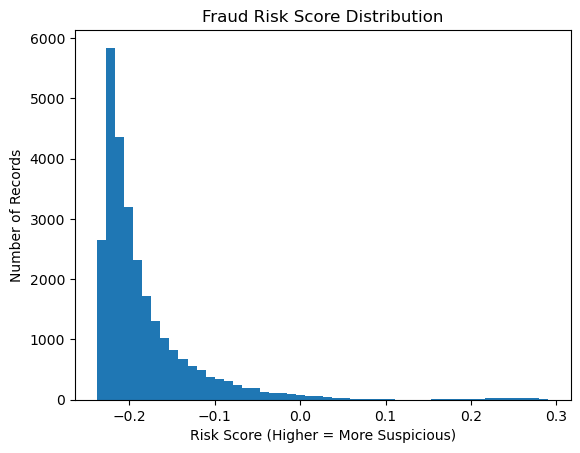

In [29]:
import matplotlib.pyplot as plt

plt.hist(data["risk_score"], bins=50)
plt.title("Fraud Risk Score Distribution")
plt.xlabel("Risk Score (Higher = More Suspicious)")
plt.ylabel("Number of Records")
plt.show()

In [30]:
high_risk_cases = data[data["risk_level"] == "High Risk"]
high_risk_cases.head(10)

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,3571,0.998221,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,5089,0.677602,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,2926,0.525516,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,6193,1.299169,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,3745,1.264550,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316
5,01-04-2025,Delhi,East Delhi,110092,3042,2869,1132,6242,676,221,...,14197,0.801492,1.059930,0.068644,6.474261,-1,-0.270666,High Risk,True,0.270666
6,01-04-2025,Delhi,North West Delhi,110034,1253,1134,642,3945,295,101,...,7383,0.520270,1.103965,0.058638,5.821951,-1,-0.240268,High Risk,True,0.240268
7,01-04-2025,Delhi,Shahdara,110032,252,374,429,2068,208,98,...,3442,0.250600,0.672000,0.102113,1.956250,-1,-0.208049,High Risk,True,0.208049
8,01-04-2025,Delhi,South Delhi,110074,1248,1341,301,1805,253,102,...,5060,1.228761,0.929955,0.077726,7.073770,-1,-0.228531,High Risk,True,0.228531
9,01-04-2025,Delhi,South West Delhi,110037,1063,865,489,1984,126,65,...,4603,0.779305,1.227483,0.045888,9.497537,-1,-0.224550,High Risk,True,0.224550


In [31]:
top_frauds = data.sort_values(
    by="risk_score", ascending=False
).head(10)

top_frauds[[
    "date", "state", "district", "pincode",
    "risk_score", "fraud_score"
]]

,date,state,district,pincode,risk_score,fraud_score
122,01-05-2025,Uttar Pradesh,Moradabad,244001,0.290447,-0.290447
172,01-07-2025,Delhi,West Delhi,110059,0.290447,-0.290447
11,01-04-2025,Delhi,West Delhi,110059,0.290345,-0.290345
219,01-07-2025,Uttar Pradesh,Aligarh,202001,0.289582,-0.289582
57,01-04-2025,Uttar Pradesh,Aligarh,202001,0.286704,-0.286704
156,01-06-2025,Uttar Pradesh,Moradabad,244001,0.285555,-0.285555
226,01-07-2025,Uttar Pradesh,Moradabad,244001,0.285269,-0.285269
223,01-07-2025,Uttar Pradesh,Ghaziabad,201102,0.284695,-0.284695
164,01-07-2025,Delhi,North East Delhi,110094,0.282977,-0.282977
205,01-07-2025,Punjab,Amritsar,143001,0.282119,-0.282119


In [32]:
features = [
    "total_biometric",
    "total_demographic",
    "total_enrolment",
    "bio_demo_ratio",
    "child_bio_ratio",
    "enrolment_update_ratio",
    "biometric_enrolment_ratio"
]

fraud_mean = data[data["is_fraud"]][features].mean()
normal_mean = data[~data["is_fraud"]][features].mean()

feature_diff = (fraud_mean - normal_mean).abs().sort_values(ascending=False)
feature_diff

total_demographic            1375.564286
total_biometric              1259.675920
total_enrolment               309.390463
biometric_enrolment_ratio       7.828390
bio_demo_ratio                  2.430163
child_bio_ratio                 1.411735
enrolment_update_ratio          0.014977
dtype: float64

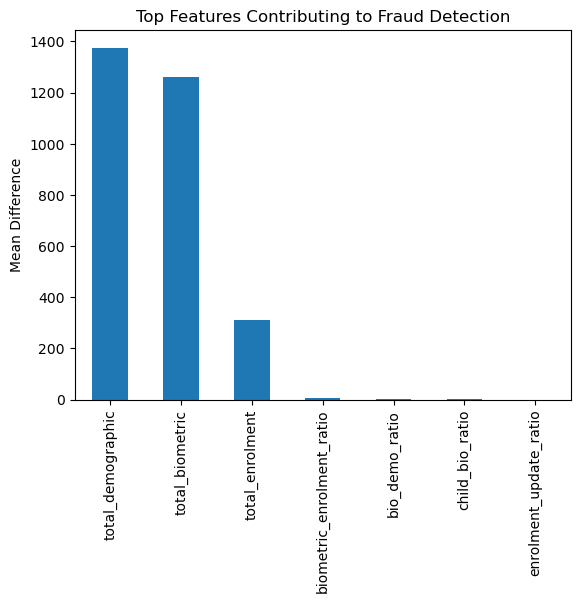

In [33]:
feature_diff.plot(kind="bar")
plt.title("Top Features Contributing to Fraud Detection")
plt.ylabel("Mean Difference")
plt.show()

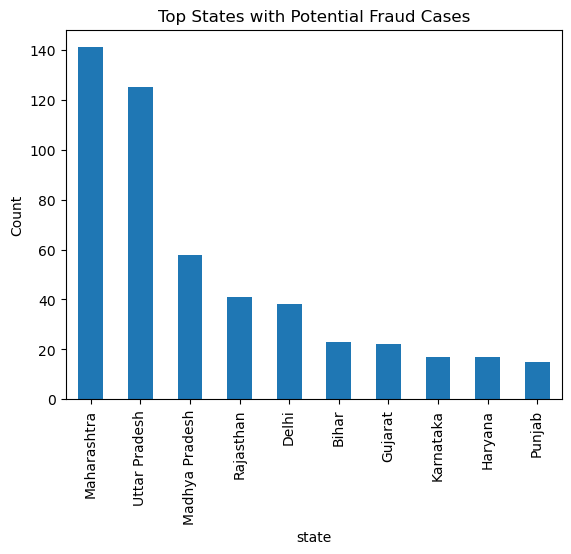

In [34]:
fraud_by_state = (
    data[data["is_fraud"]]
    .groupby("state")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

fraud_by_state.plot(kind="bar")
plt.title("Top States with Potential Fraud Cases")
plt.ylabel("Count")
plt.show()

In [35]:
data.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,3571,0.998221,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,5089,0.677602,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,2926,0.525516,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,6193,1.299169,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,3745,1.264550,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316


In [36]:
data.tail()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score
92018,19-09-2025,West Bengal,Uttar Dinajpur,733209,11,22,2,90,12,4,...,141,0.354839,0.478261,0.126984,1.941176,1,0.207836,Low Risk,False,-0.207836
92019,19-09-2025,West Bengal,Uttar Dinajpur,733210,37,49,14,283,41,10,...,434,0.288591,0.740000,0.132812,1.653846,1,0.049114,Medium Risk,False,-0.049114
92020,19-09-2025,West Bengal,Uttar Dinajpur,733215,9,26,4,117,12,5,...,173,0.286885,0.333333,0.108280,1.944444,1,0.195253,Low Risk,False,-0.195253
92021,19-09-2025,West Bengal,Uttar Dinajpur,733216,1,9,1,48,3,2,...,64,0.200000,0.100000,0.083333,1.666667,1,0.214522,Low Risk,False,-0.214522
92027,19-09-2025,West Bengal,West Midnapore,721506,6,10,3,71,21,0,...,111,0.213333,0.545455,0.230769,0.727273,1,0.164711,Low Risk,False,-0.164711


In [37]:
fraud_records = data[data["fraud_flag"] == -1]
high_risk_cases = data[data["risk_level"] == "High Risk"]

total_records = len(data)

summary = {
    "Total Records Analysed": total_records,
    "Potential Fraud Records": len(fraud_records),
    "High Risk Records": len(high_risk_cases),
    "Fraud Percentage (%)": round(
        (len(fraud_records) / total_records) * 100, 2
    )
}

pd.DataFrame(summary.items(), columns=["Metric", "Value"])

,Metric,Value
0,Total Records Analysed,27652.0
1,Potential Fraud Records,554.0
2,High Risk Records,830.0
3,Fraud Percentage (%),2.0


In [38]:
# Potential fraud based on anomaly model
potential_fraud = data[data["fraud_flag"] == -1]

print("Potential Fraud Records:", len(potential_fraud))
potential_fraud.head(15)

Potential Fraud Records: 554


,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,3571,0.998221,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,5089,0.677602,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,2926,0.525516,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,6193,1.299169,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,3745,1.264550,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316
5,01-04-2025,Delhi,East Delhi,110092,3042,2869,1132,6242,676,221,...,14197,0.801492,1.059930,0.068644,6.474261,-1,-0.270666,High Risk,True,0.270666
6,01-04-2025,Delhi,North West Delhi,110034,1253,1134,642,3945,295,101,...,7383,0.520270,1.103965,0.058638,5.821951,-1,-0.240268,High Risk,True,0.240268
7,01-04-2025,Delhi,Shahdara,110032,252,374,429,2068,208,98,...,3442,0.250600,0.672000,0.102113,1.956250,-1,-0.208049,High Risk,True,0.208049
8,01-04-2025,Delhi,South Delhi,110074,1248,1341,301,1805,253,102,...,5060,1.228761,0.929955,0.077726,7.073770,-1,-0.228531,High Risk,True,0.228531
9,01-04-2025,Delhi,South West Delhi,110037,1063,865,489,1984,126,65,...,4603,0.779305,1.227483,0.045888,9.497537,-1,-0.224550,High Risk,True,0.224550


In [39]:
# High risk records based on risk score thresholds
high_risk_cases = data[data["risk_level"] == "High Risk"]

print("High Risk Records:", len(high_risk_cases))
high_risk_cases.head(15)

High Risk Records: 830


,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_activity,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,3571,0.998221,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,5089,0.677602,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,2926,0.525516,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,6193,1.299169,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,3745,1.264550,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316
5,01-04-2025,Delhi,East Delhi,110092,3042,2869,1132,6242,676,221,...,14197,0.801492,1.059930,0.068644,6.474261,-1,-0.270666,High Risk,True,0.270666
6,01-04-2025,Delhi,North West Delhi,110034,1253,1134,642,3945,295,101,...,7383,0.520270,1.103965,0.058638,5.821951,-1,-0.240268,High Risk,True,0.240268
7,01-04-2025,Delhi,Shahdara,110032,252,374,429,2068,208,98,...,3442,0.250600,0.672000,0.102113,1.956250,-1,-0.208049,High Risk,True,0.208049
8,01-04-2025,Delhi,South Delhi,110074,1248,1341,301,1805,253,102,...,5060,1.228761,0.929955,0.077726,7.073770,-1,-0.228531,High Risk,True,0.228531
9,01-04-2025,Delhi,South West Delhi,110037,1063,865,489,1984,126,65,...,4603,0.779305,1.227483,0.045888,9.497537,-1,-0.224550,High Risk,True,0.224550


In [40]:
data["final_risk"] = data["risk_level"].apply(
    lambda x: "Potential Risk" if x in ["Medium Risk", "High Risk"] else "Low Risk"
)

In [41]:
total_records = len(data)
potential_risk_records = data[data["final_risk"] == "Potential Risk"]

summary = {
    "Total Records Analysed": total_records,
    "Potential Risk Records": len(potential_risk_records),
    "Potential Risk Percentage (%)": round(
        (len(potential_risk_records) / total_records) * 100, 2
    )
}

pd.DataFrame(summary.items(), columns=["Metric", "Value"])

,Metric,Value
0,Total Records Analysed,27652.0
1,Potential Risk Records,2766.0
2,Potential Risk Percentage (%),10.0


In [42]:
data["risk_level"].value_counts()

risk_level
Low Risk       24886
Medium Risk     1936
High Risk        830
Name: count, dtype: int64

In [43]:
data["final_risk"].value_counts()

final_risk
Low Risk          24886
Potential Risk     2766
Name: count, dtype: int64

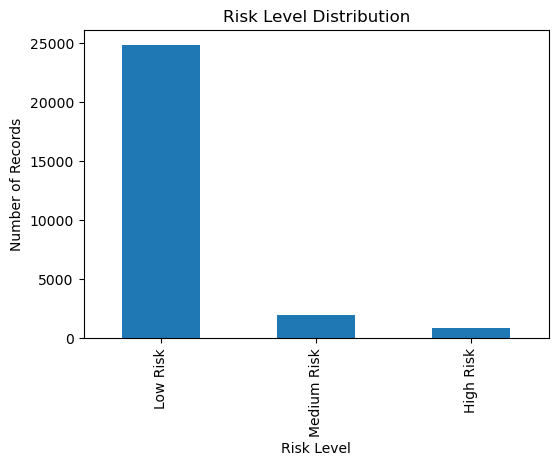

In [44]:
plt.figure(figsize=(6,4))
data["risk_level"].value_counts().plot(kind="bar")
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Number of Records")
plt.show()

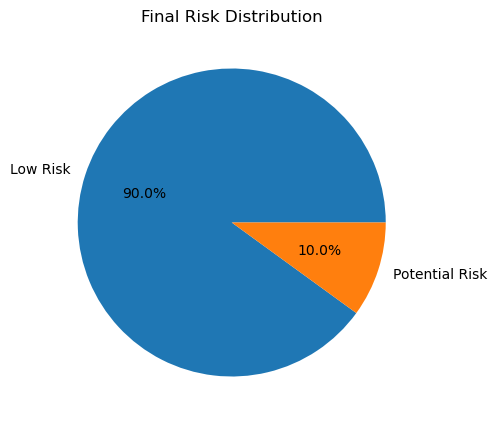

In [46]:
plt.figure(figsize=(5,5))
data["final_risk"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Final Risk Distribution")
plt.ylabel("")
plt.show()

In [48]:
import seaborn as sns

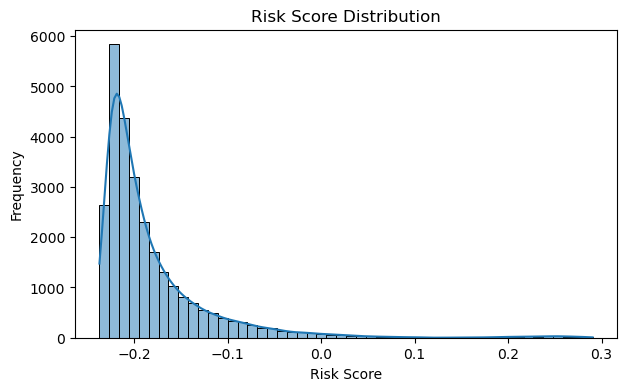

In [49]:
plt.figure(figsize=(7,4))
sns.histplot(data["risk_score"], bins=50, kde=True)
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.show()

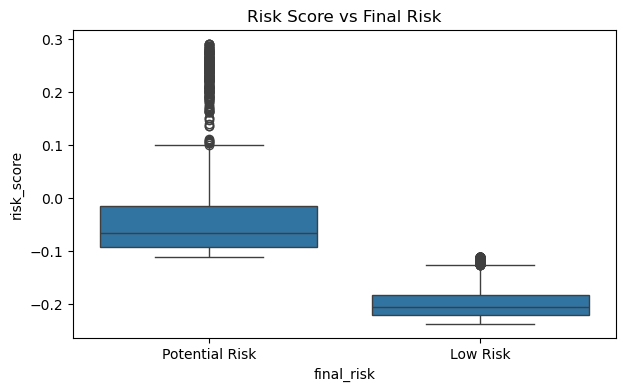

In [50]:
plt.figure(figsize=(7,4))
sns.boxplot(x="final_risk", y="risk_score", data=data)
plt.title("Risk Score vs Final Risk")
plt.show()

In [51]:
final_cases = data[
    data["final_risk"] == "Potential Risk"
]

final_cases.to_csv("final_potential_risk_cases.csv", index=False)

final_cases.head(20)

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,bio_demo_ratio,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score,final_risk
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,0.998221,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572,Potential Risk
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,0.677602,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228,Potential Risk
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,0.525516,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897,Potential Risk
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,1.299169,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670,Potential Risk
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,1.264550,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316,Potential Risk
5,01-04-2025,Delhi,East Delhi,110092,3042,2869,1132,6242,676,221,...,0.801492,1.059930,0.068644,6.474261,-1,-0.270666,High Risk,True,0.270666,Potential Risk
6,01-04-2025,Delhi,North West Delhi,110034,1253,1134,642,3945,295,101,...,0.520270,1.103965,0.058638,5.821951,-1,-0.240268,High Risk,True,0.240268,Potential Risk
7,01-04-2025,Delhi,Shahdara,110032,252,374,429,2068,208,98,...,0.250600,0.672000,0.102113,1.956250,-1,-0.208049,High Risk,True,0.208049,Potential Risk
8,01-04-2025,Delhi,South Delhi,110074,1248,1341,301,1805,253,102,...,1.228761,0.929955,0.077726,7.073770,-1,-0.228531,High Risk,True,0.228531,Potential Risk
9,01-04-2025,Delhi,South West Delhi,110037,1063,865,489,1984,126,65,...,0.779305,1.227483,0.045888,9.497537,-1,-0.224550,High Risk,True,0.224550,Potential Risk


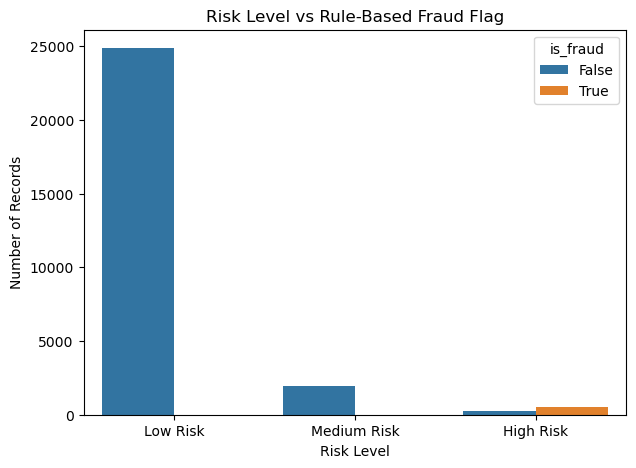

In [52]:
plt.figure(figsize=(7,5))
sns.countplot(
    data=data,
    x="risk_level",
    hue="is_fraud"
)
plt.title("Risk Level vs Rule-Based Fraud Flag")
plt.xlabel("Risk Level")
plt.ylabel("Number of Records")
plt.legend(title="is_fraud")
plt.show()

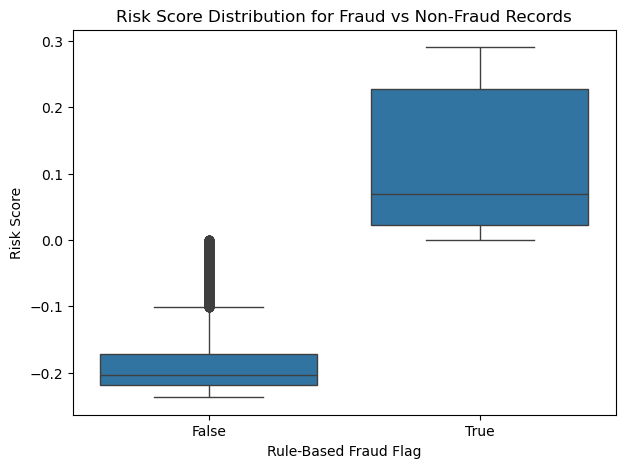

In [53]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=data,
    x="is_fraud",
    y="risk_score"
)
plt.title("Risk Score Distribution for Fraud vs Non-Fraud Records")
plt.xlabel("Rule-Based Fraud Flag")
plt.ylabel("Risk Score")
plt.show()

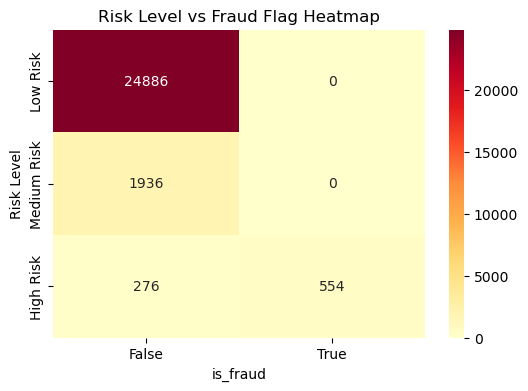

In [54]:
pivot = pd.crosstab(data["risk_level"], data["is_fraud"])

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Risk Level vs Fraud Flag Heatmap")
plt.xlabel("is_fraud")
plt.ylabel("Risk Level")
plt.show()

In [55]:
data["final_decision"] = np.select(
    [
        data["is_fraud"] == True,
        data["risk_level"] == "High Risk",
        data["risk_level"] == "Medium Risk"
    ],
    [
        "Confirmed Fraud",
        "Suspected Fraud",
        "Potential Risk"
    ],
    default="Normal"
)

In [56]:
final_output = data[
    data["final_decision"].isin(
        ["Confirmed Fraud", "Suspected Fraud", "Potential Risk"]
    )
]

In [57]:
final_output.head(20)

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,child_bio_ratio,enrolment_update_ratio,biometric_enrolment_ratio,fraud_flag,fraud_score,risk_level,is_fraud,risk_score,final_risk,final_decision
0,01-04-2025,Assam,Bongaigaon,783384,1314,369,166,1519,135,47,...,3.551351,0.060255,8.250000,-1,-0.208572,High Risk,True,0.208572,Potential Risk,Confirmed Fraud
1,01-04-2025,Bihar,Bhagalpur,812005,1059,738,465,2186,329,296,...,1.433018,0.144077,2.799065,-1,-0.242228,High Risk,True,0.242228,Potential Risk,Confirmed Fraud
2,01-04-2025,Chandigarh,Chandigarh,160036,542,426,400,1441,86,21,...,1.269321,0.041637,8.203390,-1,-0.186897,High Risk,True,0.186897,Potential Risk,Confirmed Fraud
3,01-04-2025,Chhattisgarh,Durg,491001,630,2653,451,2075,336,38,...,0.237378,0.066093,8.527273,-1,-0.227670,High Risk,True,0.227670,Potential Risk,Confirmed Fraud
4,01-04-2025,Chhattisgarh,Raipur,493225,302,1610,60,1451,299,12,...,0.187461,0.094042,5.919505,-1,-0.181316,High Risk,True,0.181316,Potential Risk,Confirmed Fraud
5,01-04-2025,Delhi,East Delhi,110092,3042,2869,1132,6242,676,221,...,1.059930,0.068644,6.474261,-1,-0.270666,High Risk,True,0.270666,Potential Risk,Confirmed Fraud
6,01-04-2025,Delhi,North West Delhi,110034,1253,1134,642,3945,295,101,...,1.103965,0.058638,5.821951,-1,-0.240268,High Risk,True,0.240268,Potential Risk,Confirmed Fraud
7,01-04-2025,Delhi,Shahdara,110032,252,374,429,2068,208,98,...,0.672000,0.102113,1.956250,-1,-0.208049,High Risk,True,0.208049,Potential Risk,Confirmed Fraud
8,01-04-2025,Delhi,South Delhi,110074,1248,1341,301,1805,253,102,...,0.929955,0.077726,7.073770,-1,-0.228531,High Risk,True,0.228531,Potential Risk,Confirmed Fraud
9,01-04-2025,Delhi,South West Delhi,110037,1063,865,489,1984,126,65,...,1.227483,0.045888,9.497537,-1,-0.224550,High Risk,True,0.224550,Potential Risk,Confirmed Fraud


In [58]:
final_output["final_decision"].value_counts()

final_decision
Potential Risk     1936
Confirmed Fraud     554
Suspected Fraud     276
Name: count, dtype: int64

In [60]:
final_output.to_csv(
    "final_fraud_anomaly_output1.csv",
    index=False
)